# Toxic Comment Classifier

Import libraries.

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

Load training and test data.

In [2]:
train_df = pd.read_csv('dataset/train.csv')
test_df = pd.read_csv('dataset/test.csv')

## Data analysis

In [3]:
train_df.sample(5)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
78933,d33bd2c57f467920,"""I dont think he sounded anti-Hatian here!!Pla...",0,0,0,0,0,0
16538,2b9b6a008072f524,Asian Supremacy\nYou voted to delete the artic...,0,0,0,0,0,0
154528,af280233fb1ad3e0,sorry but I dont remember changing the simpson...,0,0,0,0,0,0
14411,2614e86854e300a3,To quote a part of your addition:It is si o4 s...,0,0,0,0,0,0
91739,f53e8edda1cc3c38,"""\n\n Leopard again \n\nHey Cas,\n\na while ba...",0,0,0,0,0,0


In the training data, the comments are labelled as one or more of the six categories: toxic, severe toxic, obscene, threat, insult and identity hate.

In [4]:
cols_target = ['obscene','insult','toxic','severe_toxic','identity_hate','threat']

Check for missing values in numeric columns.

In [5]:
train_df.describe()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
count,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000
mean,0.095844,0.009996,0.052948,0.002996,0.049364,0.008805
std,0.294379,0.099477,0.223931,0.054650,0.216627,0.093420
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


There are no missing numeric values.\
As the mean values are very small (some way below 0.05), there probably are many positive comments which are not labelled in any of the six categories.

In [6]:
unlabelled_in_all = train_df[(train_df['toxic']!=1) & (train_df['severe_toxic']!=1) & (train_df['obscene']!=1) & 
                            (train_df['threat']!=1) & (train_df['insult']!=1) & (train_df['identity_hate']!=1)]
print('Percentage of unlabelled comments is ', len(unlabelled_in_all)/len(train_df)*100)

Percentage of unlabelled comments is  89.83211235124176


Check for any *null* comment.

In [7]:
no_comment = train_df[train_df['comment_text'].isnull()]
len(no_comment)

0

All rows in the training and test data contain comments, so there's no need to clean up null fields.\
Let's see the total rows in train, test data and the numbers for the various categories.

In [8]:
print('Total rows in test is {}'.format(len(test_df)))
print('Total rows in train is {}'.format(len(train_df)))
print(train_df[cols_target].sum())

Total rows in test is 153164
Total rows in train is 159571
obscene           8449
insult            7877
toxic            15294
severe_toxic      1595
identity_hate     1405
threat             478
dtype: int64


Let's look at the character length for the rows in the training data and record these.

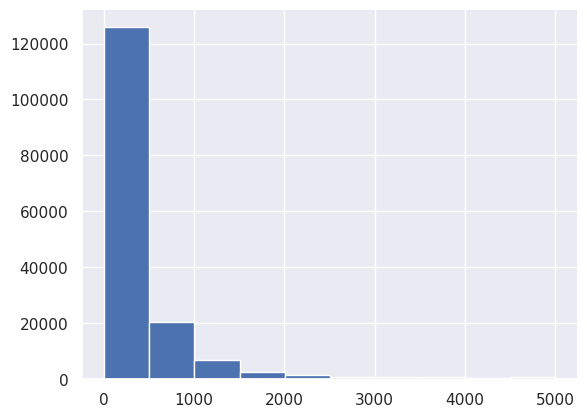

In [9]:
train_df['char_length'] = train_df['comment_text'].apply(lambda x: len(str(x)))
sns.set()
train_df['char_length'].hist()
plt.show()

Most of the text length are within 500 characters, with some up to 5,000 characters long.\
Let's examine the correlations among the target variables.

<AxesSubplot:title={'center':'Correlation of features & targets'}>

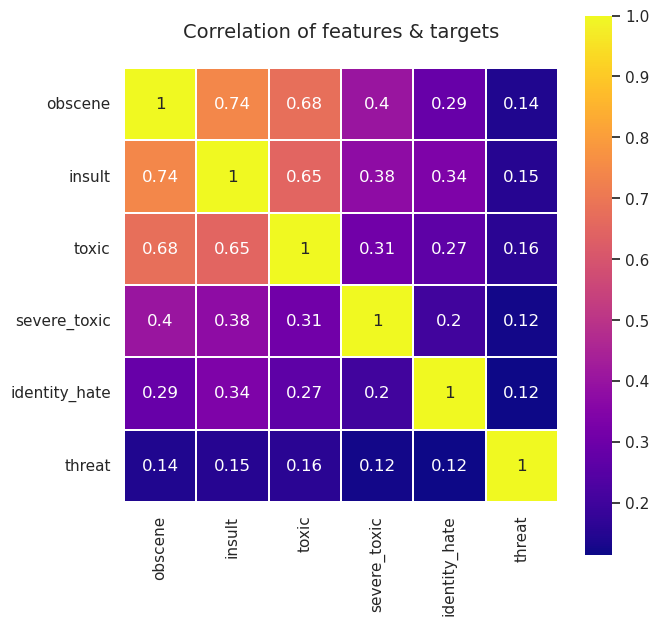

In [10]:
data = train_df[cols_target]
colormap = plt.cm.plasma
plt.figure(figsize=(7,7))
plt.title('Correlation of features & targets',y=1.05,size=14)
sns.heatmap(data.astype(float).corr(),linewidths=0.1,vmax=1.0,square=True,cmap=colormap,
           linecolor='white',annot=True)

Some of the labels are higher correlated, e.g. insult-obscene has the highest at 0.74, followed by toxic-obscene and toxic-insult.\
Let's examine character length & distribution of the comment text in the test data.

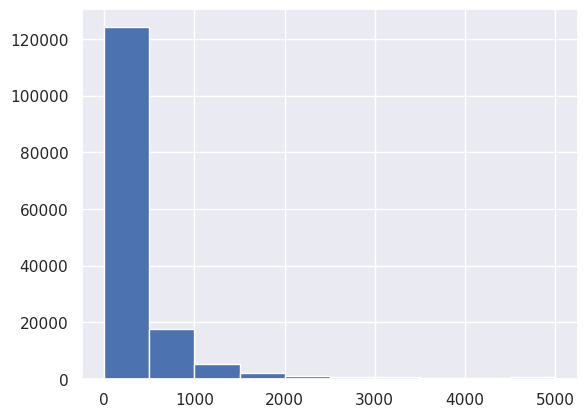

In [11]:
test_df['char_length'] = test_df['comment_text'].apply(lambda x: len(str(x)))
plt.figure()
plt.hist(test_df['char_length'])
plt.show()

The shape of character length distribution is similar between the training data and the train data.

## Vectorize the data

Define X from the entire train data and test data to be used during tokenization by Vectorizer.

In [12]:
train_df = train_df.drop('char_length',axis=1)
X = train_df.comment_text
test_X = test_df.comment_text

Instantiate TfidfVectorizer.

In [13]:
vect = TfidfVectorizer(max_features=5000,stop_words='english')

Learn the vocabulary in the training data, then use it to create a document-term matrix (and examine it).

In [14]:
X_dtm = vect.fit_transform(X)
X_dtm

<159571x5000 sparse matrix of type '<class 'numpy.float64'>'
	with 3228494 stored elements in Compressed Sparse Row format>

Transform the test data into a document-term matrix using the earlier fitted vocabulary (and examine it).

In [15]:
test_X_dtm = vect.transform(test_X)
test_X_dtm

<153164x5000 sparse matrix of type '<class 'numpy.float64'>'
	with 2663138 stored elements in Compressed Sparse Row format>

## Multi-label classifier using Logistic Regression

Instantiate the Logistic Regression model

In [16]:
logreg = LogisticRegression(C=12.0)
for label in cols_target:
    print('... Processing {}'.format(label))
    y = train_df[label]
    # train the model using X_dtm & y
    logreg.fit(X_dtm, y)
    # compute the training accuracy
    y_pred_X = logreg.predict(X_dtm)
    print('Training accuracy is {}'.format(accuracy_score(y, y_pred_X)))
    # compute the predicted probabilities for X_test_dtm
    test_y_prob = logreg.predict_proba(test_X_dtm)[:,1]

... Processing obscene


/home/alberto/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training accuracy is 0.9832488359413678
... Processing insult


/home/alberto/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training accuracy is 0.9754403995713506
... Processing toxic


/home/alberto/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training accuracy is 0.9637340118191902
... Processing severe_toxic


/home/alberto/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training accuracy is 0.9921288956013311
... Processing identity_hate


/home/alberto/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training accuracy is 0.9939650688408295
... Processing threat
Training accuracy is 0.9981262259433105


/home/alberto/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
